## Parsing unity VR log file

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import sep
import json

from dataclasses import dataclass

In [2]:
from unityvr.preproc import logproc
from unityvr.viz import viz

In [127]:
dirName = "../sample/framerateTest/"
fileName = "Log_2021-01-14_16-32-28.json"#"Log_2020-8-31_19-15-6_4.json"#


dat = logproc.openUnityLog(dirName, fileName)

for i in range(3):
    print(dat[i])
    #print(dat[i]['frame'])
    #print(json.dumps(dat[i]['data'], sort_keys=True, indent=4))

{'timeSecs': 0.0, 'frame': 0.0, 'headerNotes': '-experiment:test writing photodiode signal to log -genotype:none -flyid:none -sex:none '}
{'timeSecs': 0.0, 'frame': 1.0, 'meshGameObjectPath': 'Fly/FlyCamera3/FlyCamera3Screen', 'colliderType': 'MeshCollider', 'worldPosition': {'x': 38.428314208984375, 'y': 30.339401245117188, 'z': -52.89203643798828}, 'worldRotationDegs': {'x': 0.0, 'y': 324.0, 'z': 0.0}, 'worldScale': {'x': 95.00000762939453, 'y': 182.0, 'z': 1.0}}
{'timeSecs': 0.0, 'frame': 1.0, 'meshGameObjectPath': 'Fly/FlyCamera1/FlyCamera1Screen', 'colliderType': 'MeshCollider', 'worldPosition': {'x': 0.0, 'y': 30.339401245117188, 'z': 65.37814331054688}, 'worldRotationDegs': {'x': 0.0, 'y': 180.0, 'z': 0.0}, 'worldScale': {'x': 95.0, 'y': 182.0, 'z': 1.0}}


In [128]:
#def loadUnityLog(dirName, fileName):

#def parseUnityLog(dat):

### Construct data object from log file
#### Extract header info

In [129]:
headerwords = ["experiment", "genotype",'\n']
notes = dat[0]['headerNotes']

for i, hw in enumerate(headerwords[:-1]):
    print(hw)
    print(notes[notes.find(hw)+len(hw)+1:notes.find(headerwords[i+1])])

experiment
test writing photodiode signal to log -
genotype
none -flyid:none -sex:none


#### Pull out object positions as pandas dataframe

In [130]:
objDf = logproc.objDfFromLog(dat)
objDf

,name,collider,px,py,pz,rx,ry,rz,sx,sy,sz
0,Fly/FlyCamera3/FlyCamera3Screen,MeshCollider,38.428314,-52.892036,30.339401,0.0,0.0,324.000000,95.000008,1.0,182.0
1,Fly/FlyCamera1/FlyCamera1Screen,MeshCollider,0.000000,65.378143,30.339401,0.0,0.0,180.000000,95.000000,1.0,182.0
2,Fly/FlyCamera2/FlyCamera2Screen,MeshCollider,62.178310,20.202957,30.339401,0.0,0.0,252.000000,95.000008,1.0,182.0
3,LMlocal1,CapsuleCollider,0.000000,-200.000000,27.000000,0.0,0.0,0.000000,10.000000,10.0,30.0
4,LMlocal2,CapsuleCollider,300.000000,200.000000,27.000000,0.0,0.0,0.000000,10.000000,10.0,30.0
5,Fly/FlyCamera4/FlyCamera4Screen,MeshCollider,-38.428303,-52.892036,30.339401,0.0,0.0,35.999996,95.000000,1.0,182.0
6,NIDAQConnection,CapsuleCollider,100.000000,0.000000,10.000000,0.0,0.0,0.000000,10.000000,10.0,10.0


#### Pull out fly position as pandas dataframe
Position in VR

In [131]:
posDf = logproc.posDfFromLog(dat)
print(len(posDf))
posDf.head()

4384


,frame,time,x,y,angle
0,1.0,0.000000,-0.236640,-0.368026,0.295083
1,2.0,0.020000,-0.100986,-0.499435,0.326397
2,3.0,0.051518,-0.040674,-0.553659,0.302967
3,4.0,0.058038,-0.179408,-0.511955,0.295002
4,5.0,0.062747,-0.179408,-0.511955,0.295002


Position based on Fictrac tracking

In [132]:
ftDf = logproc.ftDfFromLog(dat)
print(len(ftDf))
ftDf.head()

4414


,frame,ficTracTReadMs,ficTracTWriteMs,dx,dy,dz
0,1.0,0.0,0.0,0.002624,0.000313,0.000198
1,1.0,3.0,7597044.0,-0.001960,0.001847,-0.000754
2,1.0,10.0,15194131.0,-0.001253,-0.011029,0.003062
3,1.0,18.0,22791462.0,0.002626,0.005941,0.000598
4,1.0,26.0,30388549.0,0.000441,-0.008604,0.002661


Fictrac updates come in at a higher rate than the VR frame rate. Fictrac can also only run for a subset of the VR run time and therefore the number of frames in fictrac and vr dataframes may not match.

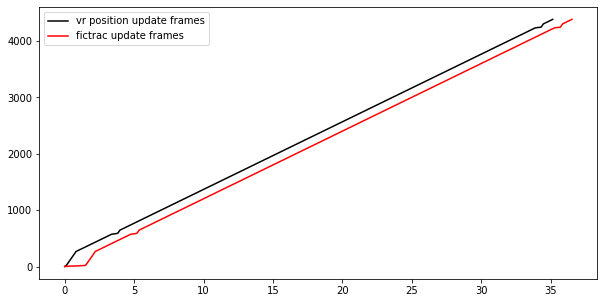

In [133]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(posDf.time, posDf.frame, 'k')
ax.plot(ftDf.ficTracTReadMs/1000, ftDf.frame, 'r')
ax.legend(['vr position update frames','fictrac update frames'])

#### Generate data object

In [137]:
# to be moved to logproc

objDfCols = ['name','collider','px','py','pz','rx','ry','rz','sx','sy','sz']

posDfCols = ['frame','time','x','y','angle']
ftDfCols = ['frame','ficTracTReadMs','ficTracTWriteMs','dx','dy','dz']

@dataclass
class unityVRexperiment:

    # metadata
    experiment: str
    genotype: str
    sex: str = 'n'
    flyid: int = 0
    date: str = 'none'
    time: str = 'none'
        
        
    imaging: bool = False
    brainregion: str = None
    
    # timeseries data
    posDf: pd.DataFrame = pd.DataFrame(columns=posDfCols)
    ftDf: pd.DataFrame = pd.DataFrame(columns=ftDfCols)
        
    # object locations
    objDf: pd.DataFrame = pd.DataFrame(columns=objDfCols)
    
    # methods
    def printMetadata(self):
        print("Experiment {} with {} (fly {}{})\nDate: {}\nTime: {}\nImaging: {}".format(self.experiment,
                                    self.genotype, self.sex,self.flyid, self.date,self.time,self.imaging))
    
    ## data wrangling
    def downsampleftDf(self):
        frameftDf = self.ftDf.groupby("frame").sum()
        frameftDf.reset_index(level=0, inplace=True)
        return frameftDf
    
    
    #def saveObject(dirName, saveName):
        

# constructor for unityVRexperiment
def constructUnityVRexperiment(dat,fileName):
    
    if 'headerNotes' in dat[0].keys():
        headerNotes = dat[0]['headerNotes']
        [exp, gt, fi ,sx] = parseHeader(headerNotes)
    else:
        exp = 'test experiment'
        gt = 'test genotype'
        fi = 'none'
        sx = 'none'
        
    [datestr, timestr] = fileName.split('.')[0].split('_')[1:]

    objDf = logproc.objDfFromLog(dat)
    posDf = logproc.posDfFromLog(dat)
    ftDf = logproc.ftDfFromLog(dat)

    uvrexperiment = unityVRexperiment(exp,gt,sx,fi,datestr, timestr,
                                    posDf=posDf,ftDf=ftDf,objDf=objDf)
    
    return uvrexperiment


def parseHeader(notes):
    hw = ["experiment", "genotype","flyid","sex","\n"]

    exp = notes[notes.find(hw[0])+len(hw[0])+1:notes.find(hw[1])]
    gt = notes[notes.find(hw[1])+len(hw[1])+1:notes.find(hw[2])]
    fi = notes[notes.find(hw[2])+len(hw[0])+1:notes.find(hw[3])]
    sx = notes[notes.find(hw[3])+len(hw[1])+1:notes.find(hw[4])]
    
    return exp, gt, fi, sx


In [139]:
uvrTest = constructUnityVRexperiment(dat,fileName)
uvrTest.printMetadata()

Experiment test writing photodiode signal to log - with none - (fly -)
Date: 2021-01-14
Time: 16-32-28
Imaging: False


In [140]:
frameftDf = uvrTest.downsampleftDf()
frameftDf.head()

,frame,ficTracTReadMs,ficTracTWriteMs,dx,dy,dz
0,1.0,968.0,1.033212e+09,-0.008260,-0.012847,0.010300
1,2.0,1276.0,1.306708e+09,0.004759,-0.004563,0.001093
2,3.0,407.0,4.178396e+08,0.002116,-0.001881,-0.000818
3,4.0,454.0,4.634268e+08,-0.004850,0.001430,-0.000278
4,6.0,2870.0,2.924903e+09,0.004937,0.010558,-0.004274


#### Extract NIDAQ-recorded photodiode trace

In [143]:
def pdDfFromLog(dat):
    pdDf = pd.DataFrame(columns=['frame','pdSig'])

    nlines = sum(1 for line in dat)

    for l in range(nlines):
        if 'data' in dat[l].keys(): 
            line = dat[l]['data']
        else:
            line = dat[l]
        if('tracePD' in line.keys()):
            framedat = {'frame': line['frame'],
                        'pdSig': line['tracePD']}
            pdDf = pdDf.append(framedat, ignore_index = True)
            
    return pdDf

In [144]:
pdDf = pdDfFromLog(dat)
pdDf.head()

,frame,pdSig
0,2.0,0.078625
1,2.0,0.079274
2,2.0,0.079274
3,2.0,0.079923
4,2.0,0.079923


In [153]:
from scipy.signal import savgol_filter

pdDf["pdFilt"] = savgol_filter(pdDf.pdSig, 5, 2)
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(pdDf.pdSig[100:500], '.-')

ModuleNotFoundError: No module named 'scipy'

### Vizualize

#### Frame rate

Unity log framerate: 124.71996658445137
Fictrac log framerate: 120.84046266511533
Down sampled fictrac log framerate: 216.79983961966934


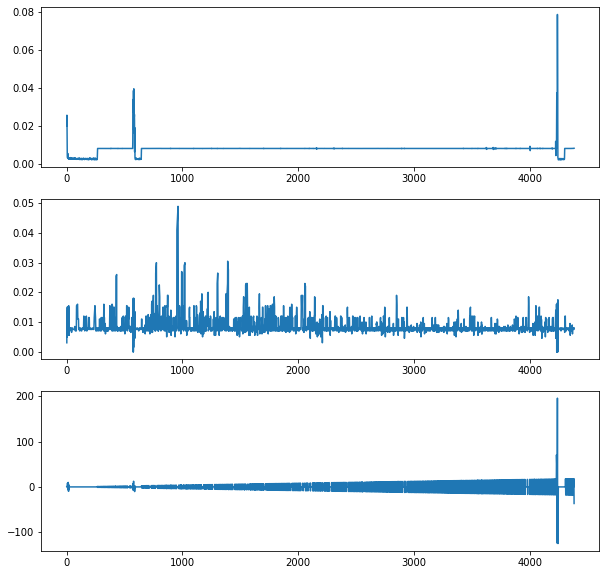

In [141]:
fig, axs = plt.subplots(3,1, figsize=(10,10))

axs[0].plot(uvrTest.posDf.frame, np.gradient(uvrTest.posDf.time))
axs[1].plot(uvrTest.ftDf.frame, np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.))
axs[2].plot(uvrTest.downsampleftDf().frame,np.gradient(uvrTest.downsampleftDf().ficTracTReadMs/1000.))

print('Unity log framerate: {}'.format(1/np.gradient(uvrTest.posDf.time).mean()))
print('Fictrac log framerate: {}'.format(1/np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.).mean()))
print('Down sampled fictrac log framerate: {}'.format(1/np.gradient(uvrTest.downsampleftDf().ficTracTReadMs/1000).mean()))

**Compare to fictrac data log**

In [97]:
ftlog = 'fictrac-20210113_191354.dat'
ftdat = pd.read_csv(sep.join([dirName, ftlog]), header=None)

In [108]:
ftdat.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,14257021460976,0,0,6.923518e+07
1,1,0.004147,-0.003180,0.010677,4269.942690,0.003773,0.011271,0.000188,0.004147,-0.003180,...,-0.003774,6.282997,5.960194,0.011886,0.011271,-0.003773,14257029057982,1,7597006,6.923519e+07
2,2,-0.003169,0.002485,-0.011666,4190.178400,-0.002771,-0.012003,0.000749,0.000972,-0.000702,...,-0.000996,6.282249,2.914721,0.012318,-0.000732,-0.001002,14257036655150,2,7597168,6.923520e+07
3,3,0.005476,-0.000468,0.000069,4118.660746,0.005467,0.000375,0.000436,0.006449,-0.001168,...,-0.006463,6.281813,4.780862,0.005479,-0.000357,-0.006468,14257044253662,3,7598512,6.923521e+07
4,4,-0.004719,0.000039,0.004118,3903.749013,-0.004848,0.003796,-0.001151,0.001732,-0.001118,...,-0.001618,6.282963,0.906482,0.006157,0.003439,-0.001621,14257051844806,4,7591144,6.923521e+07


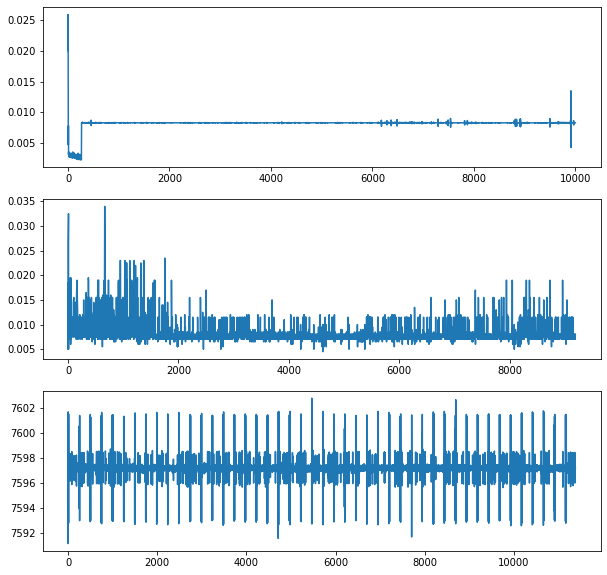

In [126]:
fig, axs = plt.subplots(3,1, figsize=(10,10))

axs[0].plot(uvrTest.posDf.frame, np.gradient(uvrTest.posDf.time))
axs[1].plot(uvrTest.ftDf.frame, np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.))

ftdt = ftdat[23].values/1000.
axs[2].plot(ftdat[0].values[1:-1], ftdt[1:-1])

#### Vizualize trajectory and object positions

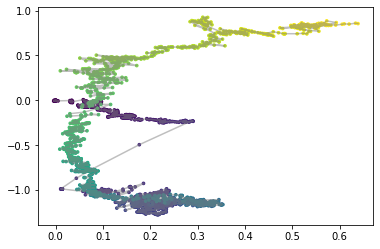

In [62]:
ballr = 45
#plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
#plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

# See Seelig 2010 for reference on equations (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2945246/)
fta = np.cumsum(ftDf['dz'])
fty = np.cumsum(ballr*np.pi/180*ftDf['dy']*np.cos(fta) - ballr*np.pi/180*ftDf['dx']*np.sin(fta))
ftx = np.cumsum(ballr*np.pi/180*ftDf['dy']*np.sin(fta) + ballr*np.pi/180*ftDf['dx']*np.cos(fta))
plt.plot(ftx[0:3000], fty[0:3000],color='grey',alpha=0.5)
plt.scatter(ftx[0:3000], fty[0:3000],s=7,c=ftDf['frame'][0:3000],cmap='viridis')

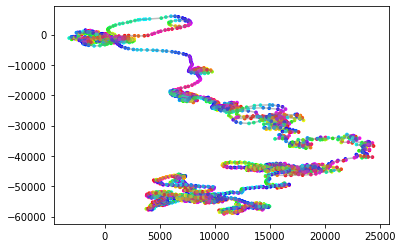

In [63]:
plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['angle'],cmap='hsv')

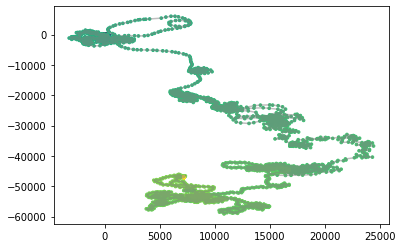

In [64]:
plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

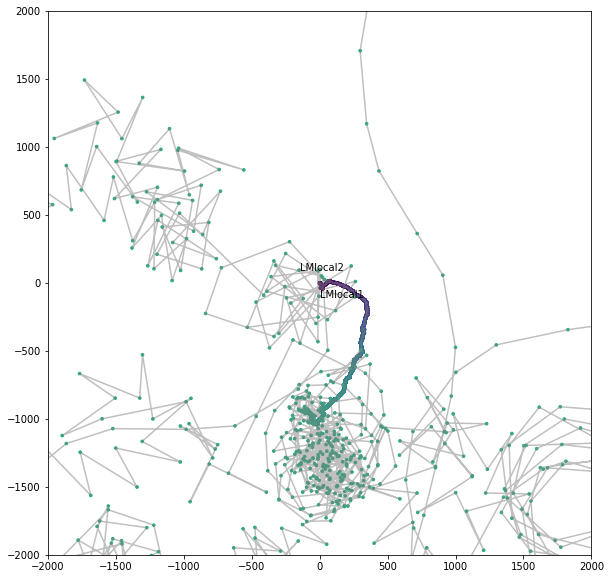

In [66]:
fig = viz.plotVRpathWithObjects(uvrTest, limx=[-2000,2000], limy=[-2000,2000],myfigsize=(10,10))